参考文档，实现a股的价格聚类
http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py
使用方法，当发现一个聚类中的某只股票上涨后，其他股票还没有涨，那么无脑买入这些没有涨的股票

In [3]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
import pickle

In [2]:
sb = ts.get_stock_basics()
sb.head()

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
603157,N拉夏,服饰,上海,11.77,0.55,5.48,606343.69,365973.69,23172.80,154068.30,...,7.02,1.73,20170925,124969.30,2.28,0.0,0.0,65.08,6.58,54018.0
002901,大博医疗,医疗保健,福建,27.83,0.40,4.00,74785.65,47986.80,19636.63,2599.88,...,1.77,10.35,20170922,21635.90,0.54,0.0,0.0,82.64,47.69,77867.0
300570,太辰光,元器件,深圳,57.17,0.57,2.30,117180.27,94308.25,4235.72,51240.80,...,4.62,5.15,20161206,27215.27,1.18,0.0,0.0,35.53,20.76,21434.0
603321,梅轮电梯,运输设备,浙江,53.41,0.77,3.07,100797.21,66458.55,20185.42,0.00,...,2.38,6.49,20170915,28370.15,0.92,0.0,0.0,31.76,11.68,74432.0
603386,广东骏亚,元器件,广东,76.48,0.51,2.02,94767.65,48869.67,35564.53,1066.33,...,1.95,10.85,20170912,12370.92,0.61,0.0,0.0,16.82,6.30,47504.0


In [4]:
hs300 = ts.get_hs300s()
hs300.head()

,code,name,date,weight
0,600436,片仔癀,2017-09-01,0.15
1,002304,洋河股份,2017-09-01,0.49
2,000792,盐湖股份,2017-09-01,0.15
3,600309,万华化学,2017-09-01,0.47
4,000568,泸州老窖,2017-09-01,0.36


In [34]:
codes = hs300['code'][:30]
cnames = hs300['name'][:30]
codes[:2]

0    600436
1    002304
Name: code, dtype: object

In [8]:
prices = [ts.get_hist_data(c) for c in codes]

In [9]:
prices[0].head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
date,,,,,,,,,,,,,,
2017-09-25,55.20,58.49,57.96,55.16,152858.17,3.11,5.67,55.770,55.627,55.235,49116.06,42572.70,38245.48,2.53
2017-09-22,55.10,55.15,54.85,54.73,19273.95,-0.27,-0.49,55.384,55.320,55.101,25545.77,29753.17,32790.65,0.32
2017-09-21,55.27,55.29,55.12,55.02,13993.01,-0.09,-0.16,55.582,55.341,55.138,28695.76,30557.16,32869.47,0.23
2017-09-20,55.68,55.68,55.21,55.00,29107.51,-0.50,-0.90,55.620,55.304,55.144,33256.40,31922.84,33233.31,0.48
2017-09-19,56.10,56.47,55.71,55.42,30347.64,-0.32,-0.57,55.684,55.250,55.154,37507.02,32493.35,32604.27,0.50


In [14]:
m = 0
for index,p in enumerate(prices):
    if m < len(p):
        m = len(p)
        print('index',index,'m',m)


index 0 m 725
index 1 m 732


In [22]:
price_a = prices[0]
price_b = prices[1]

In [26]:
price_a=price_a.reindex(index=price_b.index, method='ffill', copy=True)
len(price_a),len(price_b.index)

(732, 732)

In [27]:
for index,p in enumerate(prices):
    if len(p)!=len(price_b):
        p = p.reindex(index=price_b.index, method='ffill')
        prices[index] = p
        

In [28]:
for p in prices:
    print(len(p))

732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732
732


In [29]:
names = np.array(codes)
open = np.vstack([q.open for q in prices])
close = np.vstack([q.close for q in prices])

In [30]:
variation = close-open
edge_model = covariance.GraphLassoCV()
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

In [35]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(cnames[labels == i])))

Cluster 1: 华东医药
Cluster 2: 洋河股份, 泸州老窖, 五 粮 液, 贵州茅台
Cluster 3: 片仔癀, 盐湖股份, 复星医药, 同仁堂, 东阿阿胶, 云南白药, 白云山, 安信信托
Cluster 4: 美年健康
Cluster 5: 东旭光电, 鹏博士, 华兰生物, 光线传媒, 康美药业, 同方股份, 大华股份
Cluster 6: 万华化学, 伊利股份, 华域汽车, 上港集团, 南方航空, 上海机场, 中国石化
Cluster 7: 牧原股份
Cluster 8: 长江电力


In [32]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

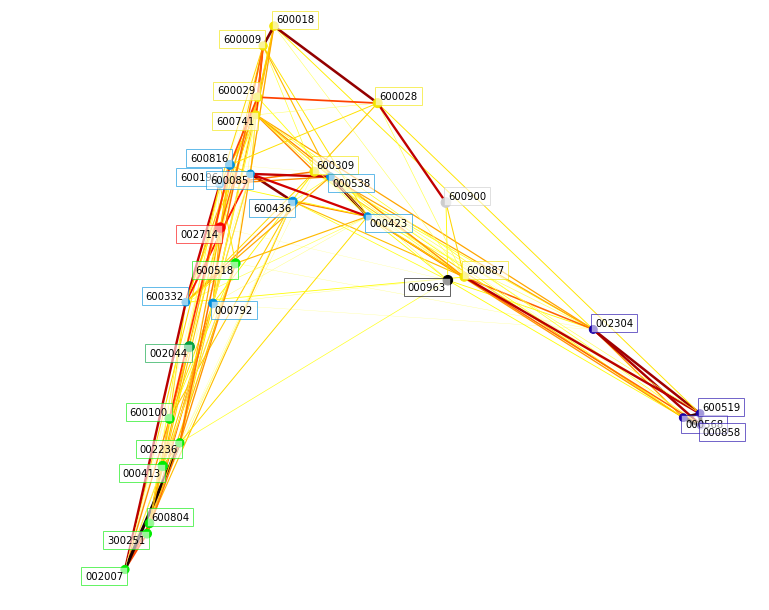

In [37]:
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()